In [1]:
!kaggle competitions download -c cassava-leaf-disease-classification

100%|█████████████████████████████████████▉| 5.76G/5.76G [25:36<00:00, 4.29MB/s]
100%|██████████████████████████████████████| 5.76G/5.76G [25:36<00:00, 4.03MB/s]


In [1]:
!unzip -q cassava-leaf-disease-classification.zip -d cassava-leaf-disease-classification

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.preprocessing as preprocessing
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
logical = tf.config.list_logical_devices('GPU')
print(len(gpus), 'Physical GPUs', len(logical), 'Logical GPUs')

tf.random.set_seed(666)

1 Physical GPUs 1 Logical GPUs


In [2]:
samples_df = pd.read_csv('./cassava-leaf-disease-classification/train.csv')
samples_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [3]:
TRAIN_FOLDER = './cassava-leaf-disease-classification/train_images/'
samples_df['filepath'] = TRAIN_FOLDER + samples_df['image_id']
samples_df['label_col'] = samples_df['label'].astype(str)
samples_df.head()

,image_id,label,filepath,label_col
0,1000015157.jpg,0,./cassava-leaf-disease-classification/train_im...,0
1,1000201771.jpg,3,./cassava-leaf-disease-classification/train_im...,3
2,100042118.jpg,1,./cassava-leaf-disease-classification/train_im...,1
3,1000723321.jpg,1,./cassava-leaf-disease-classification/train_im...,1
4,1000812911.jpg,3,./cassava-leaf-disease-classification/train_im...,3


In [4]:
CLASSES = sorted(samples_df.label_col.unique())
print(CLASSES)

['0', '1', '2', '3', '4']


In [5]:
training_percentage = 0.8
samples_df = samples_df.sample(frac=1)
training_size = int(len(samples_df) * training_percentage)
validation_size = len(samples_df) - training_size
training_df = samples_df[:training_size]
validation_df = samples_df[training_size:]

print('training size: ', training_size)
print('vlaidation size: ', validation_size)

training_df.head()

training size:  17117
vlaidation size:  4280


,image_id,label,filepath,label_col
9566,2696226006.jpg,0,./cassava-leaf-disease-classification/train_im...,0
9182,2623148776.jpg,1,./cassava-leaf-disease-classification/train_im...,1
19385,620158263.jpg,4,./cassava-leaf-disease-classification/train_im...,4
9727,2725135519.jpg,3,./cassava-leaf-disease-classification/train_im...,3
7426,232481441.jpg,3,./cassava-leaf-disease-classification/train_im...,3


In [6]:
test_df = pd.read_csv('./cassava-leaf-disease-classification/sample_submission.csv')
test_df.head()

,image_id,label
0,2216849948.jpg,4


Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.
classes:  {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


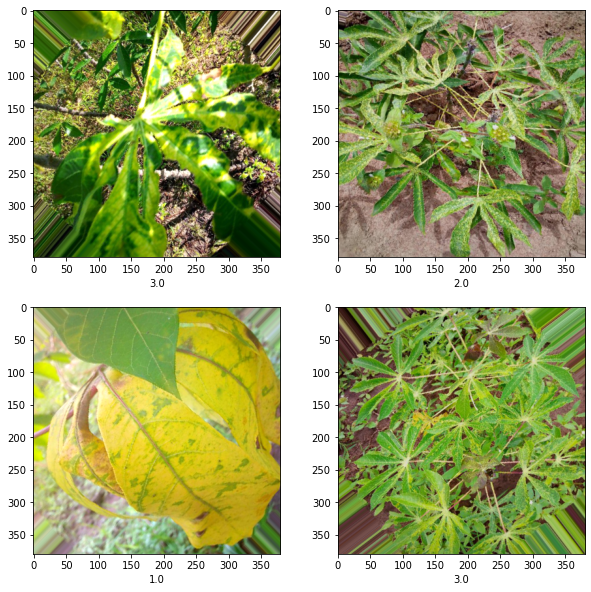

In [14]:
ImageDataGenerator = preprocessing.image.ImageDataGenerator

training_generator = ImageDataGenerator(zoom_range=(0.8, 1.0),
                                        rotation_range=60,
                                        shear_range=0.5,
                                        brightness_range=(0.8, 1.2),
                                        horizontal_flip=True,
                                        vertical_flip=True)

validation_generator = ImageDataGenerator()

BATCH_SIZE = 8
IMAGE_SIZE = 380
training_dg = training_generator.flow_from_dataframe(training_df,
                                                     x_col='filepath', y_col='label_col',
                                                     target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                     batch_size=BATCH_SIZE, shuffle=True,
                                                     class_mode='sparse')

validation_dg = validation_generator.flow_from_dataframe(validation_df,
                                                         x_col='filepath', y_col='label_col',
                                                         target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='sparse')

print('classes: ', training_dg.class_indices)
print(validation_dg.class_indices)

plt.figure(figsize=(10, 10))
for batch in training_dg:
  images, labels = batch
  for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i, ...].astype(np.uint8))
    plt.xlabel(str(labels[i]))
  plt.show()
  break

In [9]:
def build_model():
  model = keras.Sequential([
    keras.applications.EfficientNetB3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                      weights='imagenet',
                                      include_top=False,
                                      pooling='avg',
                                      drop_connect_rate=0.6),
    layers.Dropout(0.5),
    layers.Dense(256),
    layers.Dropout(0.3),
    layers.Activation('relu'),
    layers.Dense(len(CLASSES), activation="softmax"),
  ])
  model.compile(optimizer=optimizers.Adam(1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])
  return model


keras.backend.clear_session()
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 11,178,292
Trainable params: 11,090,989
Non-trainable params: 87,303
_______________________________________

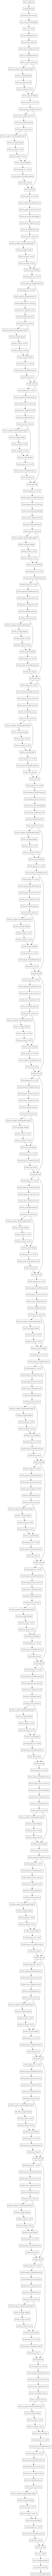

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model.get_layer('efficientnetb3'), to_file='conv_base.png')

In [12]:
def process_image_data(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = model.get_layer('efficientnetb3').get_layer('rescaling')(image)
  return image

AUTOTUNE = tf.data.experimental.AUTOTUNE
image_data = tf.data.Dataset.from_tensor_slices((samples_df.filepath.values))
image_data = image_data.map(process_image_data, num_parallel_calls=AUTOTUNE)
image_data = image_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
model.get_layer('efficientnetb3').get_layer('normalization').adapt(image_data)

In [15]:
def schedule(epoch, lr):
  if epoch in [10, 20]:
    return lr / 10.0
  return lr

save_point = callbacks.ModelCheckpoint(filepath='leaf_best_model.h5',
                                       monitor='val_accuracy',
                                       save_best_only=True, verbose=True)
scheduler = callbacks.LearningRateScheduler(schedule, verbose=True)


train_history = model.fit(training_dg,
                          epochs=30,
                          validation_data=validation_dg,
                          callbacks=[save_point, scheduler])


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 1/30
2140/2140 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.7553
Epoch 00001: val_accuracy improved from -inf to 0.84673, saving model to leaf_best_model.h5
2140/2140 [==============================] - 711s 332ms/step - loss: 0.6883 - accuracy: 0.7553 - val_loss: 0.4627 - val_accuracy: 0.8467

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 2/30
2140/2140 [==============================] - ETA: 0s - loss: 0.5154 - accuracy: 0.8260
Epoch 00002: val_accuracy improved from 0.84673 to 0.85140, saving model to leaf_best_model.h5
2140/2140 [==============================] - 621s 290ms/step - loss: 0.5154 - accuracy: 0.8260 - val_loss: 0.4497 - val_accuracy: 0.8514

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 3/30
2140/2140 [==============================] - ETA: 0s - loss: 0.4673 - accurac

2140/2140 [==============================] - ETA: 0s - loss: 0.2436 - accuracy: 0.9168
Epoch 00021: val_accuracy did not improve from 0.88014
2140/2140 [==============================] - 597s 279ms/step - loss: 0.2436 - accuracy: 0.9168 - val_loss: 0.4025 - val_accuracy: 0.8759

Epoch 00022: LearningRateScheduler reducing learning rate to 9.999999974752427e-07.
Epoch 22/30
2140/2140 [==============================] - ETA: 0s - loss: 0.2402 - accuracy: 0.9152
Epoch 00022: val_accuracy did not improve from 0.88014
2140/2140 [==============================] - 599s 280ms/step - loss: 0.2402 - accuracy: 0.9152 - val_loss: 0.4033 - val_accuracy: 0.8745

Epoch 00023: LearningRateScheduler reducing learning rate to 9.999999974752427e-07.
Epoch 23/30
2140/2140 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.9187
Epoch 00023: val_accuracy did not improve from 0.88014
2140/2140 [==============================] - 598s 279ms/step - loss: 0.2337 - accuracy: 0.9187 - val_loss:

In [27]:
from tqdm import tqdm
from PIL import Image

TEST_FOLDER = 'cassava-leaf-disease-classification/test_images'

def predict_test():
  prediction = []
  for i in tqdm(range(len(test_df.values))):
    row = test_df.values[i]
    img_path = os.path.join(TEST_FOLDER, row[0])
    image = Image.open(img_path).resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image).reshape([-1, IMAGE_SIZE, IMAGE_SIZE, 3])
    ans = model.predict(image.astype(np.float32))
    label = np.argmax(ans[0])
    prediction.append(label)
    print(ans[0])
  return prediction


model.load_weights('./leaf_best_model.h5')
test_df['label'] = predict_test()

100%|██████████| 1/1 [00:00<00:00, 22.88it/s]

[0.00728184 0.00135561 0.07734108 0.00239658 0.91162485]


In [22]:
test_df.to_csv("submission.csv", index=False)

In [23]:
test_df

,image_id,label
0,2216849948.jpg,4
